In [51]:
# Linalg imports
import jax.numpy as np
from jax import random
from jax import jit
from jax import lax
import argparse
# Jax MD imports
from jax_md import space, smap, energy, minimize, quantity, simulate

# Helper imports
from rich.progress import track

# Plotting imports
import matplotlib.pyplot as plt

from tqdm import tqdm
import bottleneck as bn

In [52]:
# Parameters to correctly instantiate the simulation box.
rho_argon = 1.40  # g/cm³
mass_argon = 39.95  # g/mol
avogadro = 6.022e23  # atoms/mol
kb = 8.617e-5  # Boltzmann constant

# Calculate number density in atoms/cm³
n_argon = (rho_argon * avogadro) / mass_argon

# Continuing from the previous calculation
n_argon_cm3 = n_argon  # This is in atoms/cm³

# Conversion factor from cm³ to Å³
conversion_factor = 1e24  # (10^8)^3

# Convert number density to atoms/Å³ for use in simulations
n_argon_A3 = n_argon_cm3 / conversion_factor

/tmp/ipykernel_1124984/459390091.py:16: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  initial_positions = random.uniform(


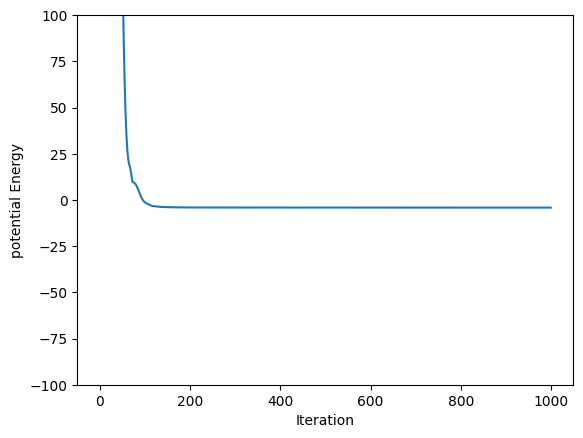

 10%|█         | 10150/100000 [00:04<00:42, 2123.50it/s]


KeyboardInterrupt: 

In [53]:
# Get the initial conditions of the simulation
n_particles = 64
dimension = 3
temperature_list = [85,100,115,130,145,160]  # In Kelvin
dt=0.1  # Time step

# Compute the box size
box_size = quantity.box_size_at_number_density(n_particles, n_argon_A3, dimension)

# Get displacement function
displacement, shift = space.periodic(box_size) #displacement: calc wrapped dist; shift: wrap pos

# Set initial positions of particles.
key = random.PRNGKey(0)
initial_positions = random.uniform(
    key, (n_particles, dimension), minval=0.0, maxval=box_size, dtype=np.float64
)
# Lennard-Jones potential with standard argon parameters (epsilon and sigma)
import jax_md
sigma = 3.4  # Distance at which the potential reaches its minimum; unit Angstrom
epsilon = 0.0103  # Depth of the potential well; unit eV
energy_fn = jax_md.energy.lennard_jones_pair(displacement, sigma=sigma, epsilon=epsilon)



In [ ]:


fire_init, fire_apply = minimize.fire_descent(energy_fn, shift)
fire_apply = jit(fire_apply)
fire_state = fire_init(initial_positions)

# Perform the minimization
energy = []

# Adjust the minimisation steps until it converges
for i in range(1000):
  fire_state = fire_apply(fire_state)
  energy += [energy_fn(fire_state.position)]
# Make a plot of the energy as a function of the iteration to see convergence.
plt.plot(energy)
plt.xlabel('Iteration')
plt.ylabel('potential Energy')
plt.ylim(-100, 100)
plt.show()


In [ ]:

# Initialize velocities according to the Maxwell-Boltzmann distribution
key, split = random.split(key)
kT = kb * temperature

# Integrate the equations of motion using the Velocity Verlet method
init_fn, apply_fn = simulate.nve(energy_fn, shift, dt)
state = init_fn(key, fire_state.position, kT)
def compute_potential_energy(state):
    """
    Compute the potential energy of the system.

    Parameters
    ----------
    state 
        The current state of the simulation.
    """
    # Implement the function
    potential_energy = energy_fn(state.position)
    return potential_energy

def compute_kinetic_energy(state):
    """
    Compute the kinetic energy of the system.

    Parameters
    ----------
    state 
        The current state of the simulation.
    """
    # Implement the function
    kinetic_energy=quantity.kinetic_energy(momentum=state.momentum)
    return kinetic_energy
# Run the simulation and print the energy


In [ ]:

num_steps = 100000  # Simulation steps

potential_energy = []
kinetic_energy = []
trajectory = []
vel = []
for step in tqdm(range(num_steps)):
    state = apply_fn(state)  # Update the state
    # Record at certain intervals
    if step % 50 == 0:
        # Compute the potential and kinetic energy
        potential_energy.append(compute_potential_energy(state))
        kinetic_energy.append(compute_kinetic_energy(state))
        trajectory.append(state.position)
        vel.append(state.velocity)
        # Add some trajectory recording here


In [ ]:

# Plot the potential, kinetic, and total energy. 1/2 m v^2 = d*N*Kb*T/2
potential_energy=bn.move_mean(potential_energy, window=5, min_count=1)
kinetic_energy=bn.move_mean(kinetic_energy, window=5, min_count=1)
time=np.linspace(0,num_steps*dt,len(potential_energy))
plt.plot(time,potential_energy, label=f'Potential Energy; mean = {np.mean(potential_energy):.2f} eV')
plt.plot(time,kinetic_energy, label='Kinetic Energy')
plt.plot(time,np.array(potential_energy) + np.array(kinetic_energy), label='Total Energy')
plt.xlabel('Time ')
plt.ylabel('Energy [eV]')    
plt.legend()
plt.show()
# Compute the pair correlation function


In [ ]:

radii = np.linspace(0.1, box_size / 2, 200)
gr = quantity.pair_correlation(displacement, radii, 0.033, compute_average=True)

# The above function computes the pair correlation function for a single frame.
# Take your generated trajectory and compute the average pair correlation function.
# Plot the average pair correlation function and compare different temperatures.
# Is the normalisation correct? If not, how would you correct it?
rdf=np.zeros_like(gr(trajectory[0]))
pressure=[]
temp=[]
for i in tqdm(range(len(trajectory))):
    rdf+=np.array(gr(trajectory[i]))
plt.plot(radii,rdf/len(trajectory))
plt.show()


In [ ]:

trajectory = np.array(trajectory)

# Calculate the displacement vector for each time step
def msd(x, dt):
    n = int(np.shape(x)[0] / dt)
    deltaX = 0.0
    for j in range(1, n):
        deltaX += np.sum((x[j * dt, :, :] - x[(j - 1) * dt, :, :]) ** 2)
    return 1 / n * np.mean(deltaX.flatten())

for i in tqdm(range(1,500)):
    plt.plot(i,msd(trajectory,i),'k*')